<a href="https://colab.research.google.com/github/AlejandraOcampo23/FinanzasComp/blob/main/Taller_final%E2%80%94_Bohorquez%2C_Malagon%2C_Ocampo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Carlos Bohorquez, Valentina Malagon, Alejandra Ocampo 

In [4]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pylab as py
from scipy.stats import norm
from scipy.stats import chi2
from scipy import stats
from scipy.optimize import linprog
import inspect
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import warnings
import cvxpy as cp
warnings.simplefilter("ignore")
!pip install yfinance
import yfinance as yf
from scipy.optimize import minimize
!pip install fitter
from fitter import Fitter, get_common_distributions, get_distributions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#Importamos la tasa del tesoro de estados unidos 
tasa = ["^IRX"]
data = yf.download(tasa,start="2016-01-01",end="2022-10-31", interval="1mo")
data = data.loc[:,"Adj Close"].dropna()
data

[*********************100%***********************]  1 of 1 completed


Date
2016-01-01    0.300
2016-02-01    0.308
2016-03-01    0.193
2016-04-01    0.193
2016-05-01    0.283
              ...  
2022-06-01    1.600
2022-07-01    2.298
2022-08-01    2.860
2022-09-01    3.180
2022-10-01    3.975
Name: Adj Close, Length: 82, dtype: float64

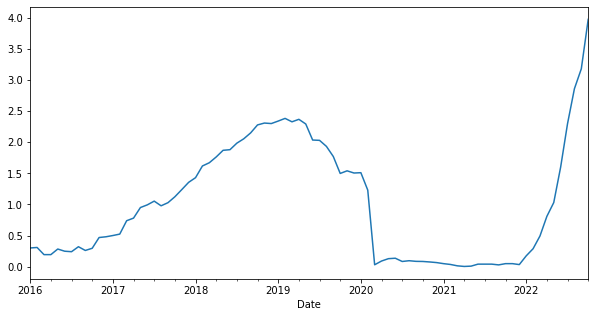

In [6]:
#Grafica de la tasa 
data.plot(figsize=(10,5));

In [7]:
#Prueba de dickey-fuller para determinar la estacionalidad 
pruebadf = adfuller(data)
print("ADF test: %f" % pruebadf[0])
print("P-value: %f" % pruebadf[1])
print("Citical values:")
for key, value in pruebadf[4].items():
  print("\t%s: %f" %(key,value))

ADF test: -1.626009
P-value: 0.469580
Citical values:
	1%: -3.519481
	5%: -2.900395
	10%: -2.587498


In [8]:
#ARMA
resDiff = sm.tsa.arma_order_select_ic(data, ic='aic', trend="nc")
resDiff

{'aic':            0           1           2
 0        NaN  191.976413  125.597758
 1  11.799970  -17.896368  -19.752936
 2 -14.308155  -34.099406  -32.215007
 3 -17.141923  -22.767447         NaN
 4 -19.603389  -31.464392  -28.997381, 'aic_min_order': (2, 1)}

In [9]:
ARIMA_01 = ARIMA(data, order=(2, 1, 1)).fit()
print(ARIMA_01.summary());
#ARIMA_01.params

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                   82
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  23.480
Date:                Mon, 21 Nov 2022   AIC                            -38.961
Time:                        01:04:48   BIC                            -29.383
Sample:                    01-01-2016   HQIC                           -35.118
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0111      0.285      3.548      0.000       0.452       1.570
ar.L2         -0.0468      0.180     -0.260      0.795      -0.400       0.306
ma.L1         -0.6586      0.299     -2.199      0.0

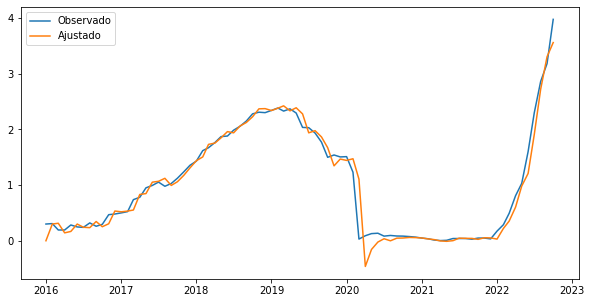

In [10]:
# Ajuste del modelo
fit_arima = ARIMA_01.predict()   # Ajuste del modelo
plt.figure(figsize=(10, 5))
plt.plot(data, label="Observado")
plt.plot(fit_arima, label="Ajustado")
plt.legend(loc="upper left")
plt.show()

In [11]:
#Valores de la prediccion ARIMA 
predict_arima = ARIMA_01.forecast(12)
predict_arima = pd.DataFrame(predict_arima.values)
#print(predict_arima.iloc[-1,:])
predict_arima

,0
0,4.489465
1,4.972381
2,5.436537
3,5.883204
4,6.313068
5,6.726761
6,7.124893
7,7.508049
8,7.876791
9,8.231662


In [12]:
#Tasas de reinversión
z1 = np.array([1.044894])
z2 = np.array([1.058832])
z3 = np.array([1.071248])
z4 = np.array([1.082316])

#Tasa de créditos (DTF 90 días proyectada por bancolombia)
rx = np.array([1.06])

#Tasa de credito segunda opcion 
ry = np.array([1.006])


In [13]:
b = np.array([100,-50,100,-50,100]) # 4 trimestres
c = np.array([0,0,0,0,0,0,0,0,0,-1])
A = np.array([[1,0,0, 1,0,0, -1,0,0,0],
              [-rx,1,0, 0,1,0, z1,-1,0,0],
              [0,-rx,1, -ry,0,1, 0,z2,-1,0],
              [0,0,-rx, 0,-ry,0, 0,0,z3,-1],
              [0,0,0, 0,0,-ry, 0,0,0,z4]])

n = len(c) 
x = cp.Variable(n) 

objective = cp.Maximize(c.T @ x )
constraints = [A @ x == b, x>=0]
prob = cp.Problem(objective, constraints)

result = prob.solve()
sol = round(pd.DataFrame(x.value),4)
sol

,0
0,138.7804
1,30.7340
2,117.5859
3,726.4957
4,1047.0536
5,0.0000
6,765.2761
7,1780.3128
8,1139.2053
9,92.3945


Tenemos una empresa que busca maximizar el exceso de capital de unos recursos pedidos al mercado, se tiene la opcion de pedir a dos tasas diferentes y los excesos seran invertidos en los bonos TES proyectados en el punto anterior. 

[*********************100%***********************]  1 of 1 completed


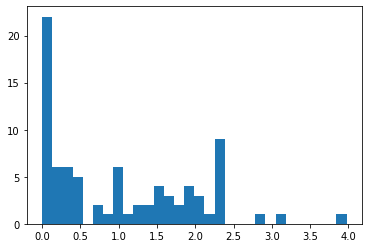

In [14]:
#Grafica de la distribucion de la tasa 
tasa = ["^IRX"]
data = yf.download(tasa,start="2016-01-01",end="2022-10-31", interval="1mo")
data = data.loc[:,"Adj Close"].dropna()
plt.hist(data,bins=30)
plt.show()

Fitting 10 distributions: 100%|██████████| 10/10 [00:00<00:00, 10.99it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
chi2,10.449361,413.637258,-155.714473,inf,0.137907,0.080216
powerlaw,10.610287,331.881300,-154.461251,inf,0.186296,0.005782
gamma,11.273563,476.201075,-149.489063,inf,0.227042,0.000339
exponpow,11.538684,408.492952,-147.582996,inf,0.132509,0.102414
lognorm,11.980423,450.816530,-144.502359,inf,0.168262,0.016908


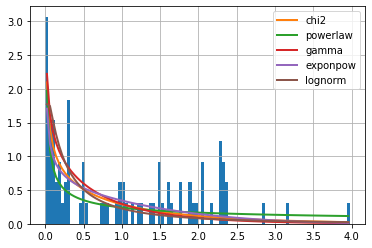

In [15]:
#Identificacion del tipo de distribucion de la tasa por metodo de errores cuadrados 
fa = Fitter(data, distributions= get_common_distributions())
fa.fit()
fa.summary()

In [16]:
fa.get_best(method = 'sumsquare_error')

{'chi2': {'df': 1.3236228090026692,
  'loc': 0.0030000000260770317,
  'scale': 0.7423897643886284}}

Usando el críterio del estadístico Kolmogorov-Smirnov se puede seleccionar una distribución Chi-Square con parámetros 'loc': 0.0030 y 'scale': 0.7423

Se constuyeron 100 trayectorias o simulaciones para la tasa (IRX) con periodicidad mensual y con duración T=1.


In [17]:
tasa = ["^IRX"]
data = yf.download(tasa,start="2016-01-01",end="2022-10-31", interval="1mo")
data = data.loc[:,"Adj Close"].dropna()
retornos = np.log(data/data.shift(1)).dropna()
mu = retornos.mean()
sigma = retornos.std()


[*********************100%***********************]  1 of 1 completed


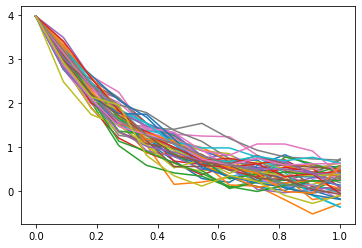

In [21]:
T = 1           # Un año
steps = 12    # Simulación mensual
k = 2.8         
NS = 10000      
y0 = data[-1]   
t = np.linspace(0,T,steps)  
dt = np.mean(np.diff(t))
drift = lambda y,t: k*(mu-y) 
diffusion = lambda y,t: sigma 
noise = np.random.normal(0,1,[steps,NS])*np.sqrt(dt) 
y = np.zeros([steps,NS])
y[0,:] = y0

for i in range(1,steps):
 y[i,:] = y[i-1] + drift(y[i-1],i*dt)*dt + diffusion(y[i-1],i*dt)*noise[i,:]

plt.plot(t,y[:,1:50])